## Initial Question: 
Correlation of Steel and other commodity prices with the Gross Margin of PACCAR business. 
Gross Margin = Revenue / Cost of Goods Sold


What is correlation: correlation is the tendency to change in relation to another, normally we seek a  tight correlation reflected with the other over period of time. Direct correlation is linear responsiveness. 

We can also measure change that is not immediate but delayed. As aspiring analysts we need to respect the fact that mathematics and statistics can be the tools uncover  

### Non linear correlation
Correlation can be linear and also non-linear. The non-linear correlation (I think of Chaos Theory, with the butterfly flapping it's wings in Japan and indirectly causing a hurricane in the midwest). By this the change can be delayed days, weeks or even months. 


Here I am comparing the largest steel manufacturer in America with Paccar to see if there is a correlation between the two. Let's start with a simple regression analysis then also try out covariance matrices and correlation matrices to see the data from a more granular level.



Ideally we would like to find a linear correlation between these two stocks holding other factors constant (scaling for say the entire S&P to see localized trends.) 

By starting with a linear regression what we are asking is y(t) = beta(x(t)) + epsilon(t)

In [66]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm

%matplotlib inline
grey = 0.7,0.7,.7
import warnings 
warnings.filterwarnings('ignore')
#sp500 = pdr.get_data_yahoo("^GSPC", start ='10/1/2016', end = '10/1/2017')['Adj Close']
dateparse = lambda x: pd.datetime.strptime(x, '%d-$m-%Y')
PCAR = pdr.get_data_yahoo("PCAR", start ='10/1/2016', end = '10/1/2017')['Adj Close']

# American steel company.
stld = pdr.get_data_yahoo("STLD", start ='10/1/2016', end = '10/1/2017')['Adj Close']
data = pd.concat([stld, PCAR], axis= 1).dropna()
data.columns = ["STLD", "PCAR"]
print(data.describe())

             STLD        PCAR
count  252.000000  252.000000
mean    33.836802   64.572034
std      3.305419    4.234457
min     23.308542   52.844646
25%     33.406514   63.137666
50%     34.615420   65.468975
75%     35.800497   67.181677
max     38.352970   72.919998


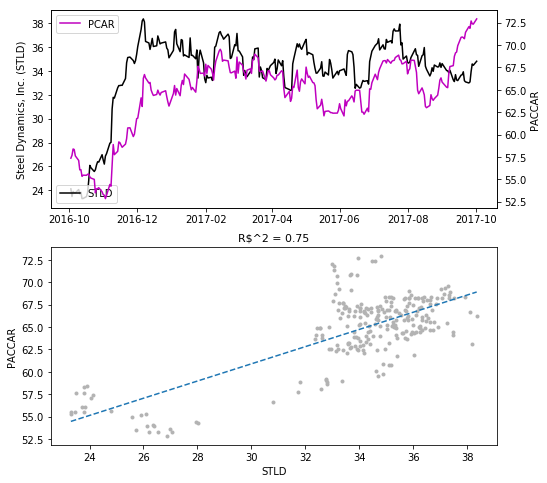

In [82]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(2,1,1)
plt.plot(data["STLD"], 'k', label = "STLD")
plt.legend(loc=3)
plt.ylabel("Steel Dynamics, Inc. (STLD)")

# now we will fit a one factor linear model
slope, intercept, r2, p_val, std_err = stats.linregress(data.STLD, data.PCAR)
xline = np.linspace(np.min(data.STLD), np.max(data.STLD), 100)
line = slope*xline + intercept

# Plot scatter plot and linear model
ax2 = ax1.twinx()
plt.plot(data.PCAR,'m',label='PCAR')
plt.ylabel("PACCAR")
plt.legend(loc="best")
plt.subplot(2,1,2)
plt.plot(data.STLD,data.PCAR,'.', color = grey)
plt.plot(xline, line,'--')
plt.xlabel("STLD")
plt.ylabel("PACCAR")
plt.title("R$^2 = %.2f" % r2, fontsize= 11)

# We should also plot the SP 500 for comparison purposes.


R squared is the ratio of explained variance to unexplained variance, in this case STLD tends to explain 75% of the variance of PACCAR, this is a strong linear correlation between these two stock prices, and we may be able to say that the performance of American steel production has a relationship with the performance of Paccar. 



I looked online, and it turns out that correlation is time-dependent, thus let's check a rolling linear correlation for a given data window size. 



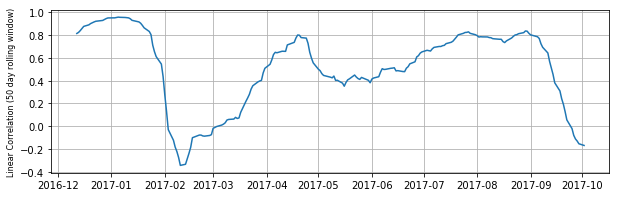

In [68]:
rollcorr = pd.rolling_corr(stld, PCAR, 50).dropna()
plt.figure(figsize=(10,3))
plt.plot(rollcorr)
plt.grid()
plt.ylabel("Linear Correlation (50 day rolling window)", fontsize= 8)

There does seem to be some correlation that stays fairly strong over time, but there are also a lot of factors that are at play. As Ben Bernanke may say, yeah there is a positive correlation, but they may both be responding the underlying shift in global demand, so let's do a multiple regression.





In [69]:
# tbond = pdr.get_data_yahoo("TLT", start ='10/1/2016', end = '10/1/2017')['Adj Close']

# tbond['DATE'] =  pd.to_datetime(tbond['DATE'], format='%Y-%m-%d')
tbond.head()

Date
2016-10-03    133.397644
2016-10-04    131.837524
2016-10-05    131.223236
2016-10-06    130.491989
2016-10-07    130.579681
Name: Adj Close, dtype: float64

For interpretabliliy sake I am going to look at the natural log applied to our stock prices.
Now we will start using the natural log instead of the unscaled inputs. 

If we look at compounded continuously you get the formula, as n the number of periods approaches infinity or otherwise stated: lim n-> infinity (1+r/n)^n = e^r
Which is an exponential function. 

Taking the natural log is the inverse of the above operation. ln(P2/P1) = r
where r is the % interest rate.
In other words, taking the difference between the log of a stock in year 2 and the log of the price in year 1 is calculating a rate of return on the holding.
Logs are useful when looking at economic information, when we look at data on the log scale, movement of 0.01 corresponds to around a 1% change at any point on the figure. Thus, we can more accurately measure volatility.

If we are trying to optimize functions logs also serve to make functions easier to differentiate. 

With logs in mind, let's run a log of steel, 20-yr interest rate, 



In [70]:
np.random.seed(7)
# Here we are creating random numbers
df = pd.DataFrame(100 + np.random.randn(100).cumsum(), columns =['price'] )
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
print(df.head())

        price  pct_change   log_ret
0  101.690526         NaN       NaN
1  101.224588   -0.004582 -0.004592
2  101.257408    0.000324  0.000324
3  101.664925    0.004025  0.004016
4  100.876002   -0.007760 -0.007790



Investors may retreat from commodities and/or stocks during periods of high uncertainty/risk aversion, thus this may be another reason why these prices tend to move together. 

In [71]:
df = pd.concat([stld, PCAR, tbond],join ='outer', axis = 1).dropna()
df.columns = ["STLD", "PCAR", "TBOND 20"]
print(df.head(10))
headers = df.columns 
dlog = pd.DataFrame() # log returns

for j in range(df.shape[1]):
    price = df.ix[:,j]
    d1 = np.log(price) - np.log(price.shift(1))
    dlog.loc[:,j] = d1
dlog.dropna(inplace=True)
dlog.columns = headers 
print(dlog.head())

                 STLD       PCAR    TBOND 20
Date                                        
2016-10-03  24.124146  57.363869  133.397644
2016-10-04  23.485420  57.676216  131.837524
2016-10-05  23.907961  58.388748  131.223236
2016-10-06  23.809696  58.330185  130.491989
2016-10-07  23.790039  57.617649  130.579681
2016-10-10  24.065187  57.110088  129.809418
2016-10-11  23.711432  56.055939  129.516891
2016-10-12  23.839176  56.075459  129.643661
2016-10-13  23.308542  55.333637  130.131210
2016-10-14  23.318371  55.460529  128.307800
                STLD      PCAR  TBOND 20
Date                                    
2016-10-04 -0.026833  0.005430 -0.011764
2016-10-05  0.017832  0.012278 -0.004670
2016-10-06 -0.004119 -0.001003 -0.005588
2016-10-07 -0.000826 -0.012291  0.000672
2016-10-10  0.011499 -0.008848 -0.005916


Here we are going to define our multiple regression model:


In [75]:
y = dlog.PCAR.values
x = [dlog.STLD, dlog["TBOND 20"]]
def reg(y,x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

print(reg(y,x).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     26.97
Date:                Sun, 15 Oct 2017   Prob (F-statistic):           2.52e-11
Time:                        13:04:30   Log-Likelihood:                 767.13
No. Observations:                 251   AIC:                            -1528.
Df Residuals:                     248   BIC:                            -1518.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3681      0.108     -3.400      0.0

Not the most useful statistics, that r^2 is downright terrible! let's look at what Kyle mentioned with gross margin, the proportion of revenues to cost of goods sold.

There are not as many data points to compare but  let's look at the xlsx file to see what it tells us. I am not sure Gross Margin is enough data points to make any extrapolation from. 



I would really like to use Principle Component Analysis as a first step to see which features have any relationship with our intended output which is the price of the stock, what we want is to keep the features that have the most variance, and get rid of things that are redundant inputs into our model. In this case we  can combine many different data sources and use the timestamp as the unique shared identifier, we could look at Twitter sentiment and see if the perception in news impacts Paccar's stock price using Latent (DA something) 

## Covariance and Correlation:
Covariance is useful to give investors insight into how two stocks move together in the future. 
This might be helpful to see if the stocks have similar change over a period of time. 

I want to refine my initial exploration and include all the largest steel manufacturers in the United States and in China. With these companies I will do the same analysis I did up above but the added information of covariance and correlation matrices. To reduce the complexity that coincides with the curse of dimensionality I will use Principle Component analysis to keep the features that retain the most variance in the input features. 



ArcelorMittal SA - 98.2 MMT. 
ArcelorMittal S.A. is the world's largest steel producer, accounting for more than 6% of global crude steel production. ...

Baosteel - 37.0 MMT. ...

POSCO - 35.4 MMT. ...

Nippon Steel Corp. ...

JFE Holdings - 31.1 MMT. ...

Jiangsu Shagang Group - 23.2 MMT. ...

Tata Steel - 23.2 MMT. ...

US Steel - 22.3 MMT.